# Tutorial 6: Synaptic Plasticity

**Duration:** ~40 minutes | **Prerequisites:** Basic Tutorials, Tutorial 5

## Learning Objectives

By the end of this tutorial, you will:

- ✅ Understand short-term plasticity (STP) mechanisms
- ✅ Implement synaptic depression and facilitation
- ✅ Learn spike-timing-dependent plasticity (STDP) principles
- ✅ Create adaptive synapses with learning rules
- ✅ Build networks with plastic connections
- ✅ Combine plasticity with network training

## Overview

Synaptic plasticity is the ability of synapses to change their strength over time. This is fundamental to learning and memory in biological brains. BrainPy supports multiple forms of plasticity:

**Types of plasticity:**
- **Short-term plasticity (STP)**: Temporary changes on timescales of milliseconds to seconds
  - Depression (STD): Synaptic strength decreases with repeated use
  - Facilitation (STF): Synaptic strength increases with repeated use
- **Long-term plasticity**: Persistent changes
  - STDP: Depends on relative timing of pre and post spikes
  - Rate-based: Depends on firing rates

Let's explore these mechanisms!

In [1]:
import brainpy
import brainstate
import brainunit as u
import braintools
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
brainstate.random.seed(42)

# Configure environment
brainstate.environ.set(dt=0.1 * u.ms)

## Part 1: Short-Term Depression (STD)

Short-term depression models the depletion of neurotransmitter resources. Each spike consumes some fraction of available resources, which recover over time.

**STD dynamics:**
$$
\frac{dx}{dt} = \frac{1 - x}{\tau_d} - u \cdot x \cdot \delta(t - t_{spike})
$$

Where:
- $x$: Fraction of available resources (0 to 1)
- $\tau_d$: Recovery time constant
- $u$: Utilization fraction per spike

**Effect:** Repeated spikes deplete resources → synaptic current decreases

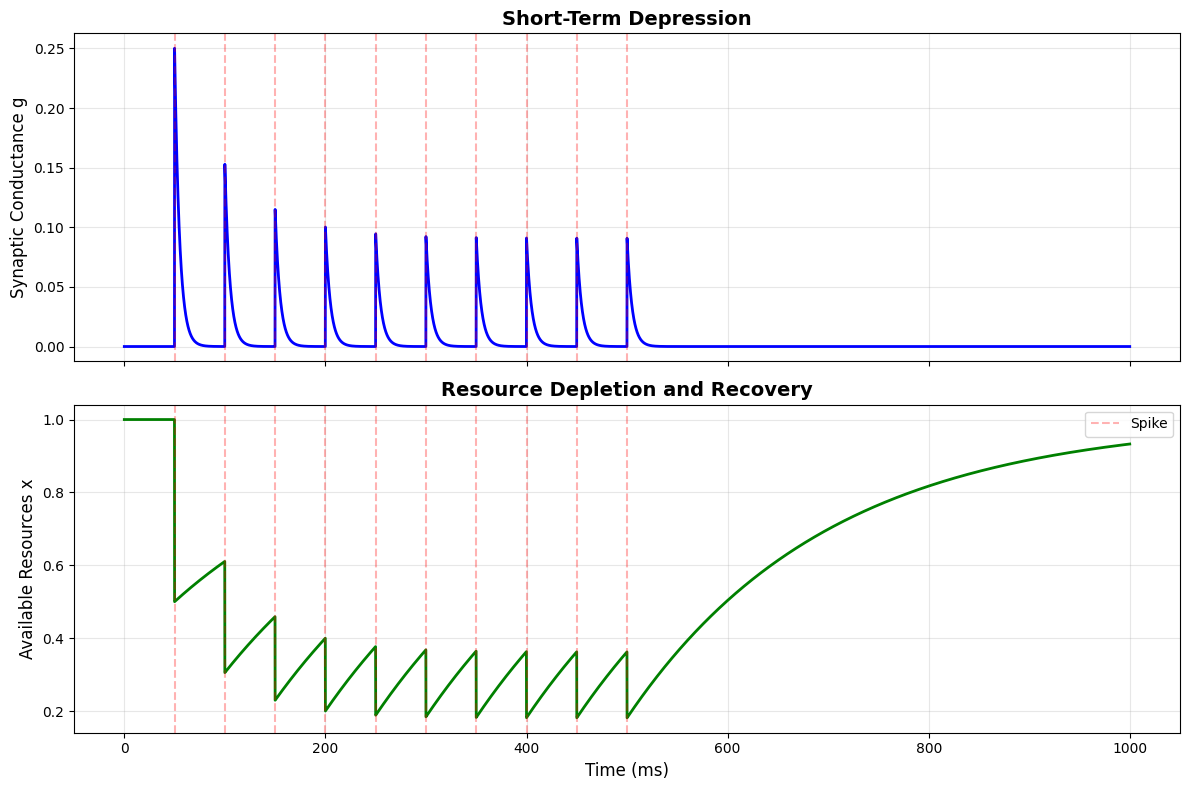

📊 STD Observations:
   • Each spike depletes available resources
   • Synaptic conductance decreases with repeated spikes
   • Resources recover exponentially between spikes
   • Implements synaptic fatigue


In [ ]:
# Create synapse with short-term depression
class STDSynapse(brainpy.state.Synapse):
    """Synapse with short-term depression."""
    
    def __init__(self, size, tau=5.0*u.ms, tau_d=200.0*u.ms, U=0.5, **kwargs):
        super().__init__(size, **kwargs)
        
        # Synapse parameters
        self.tau = tau  # Synaptic time constant
        self.tau_d = tau_d  # Depression time constant
        self.U = U  # Utilization fraction
        
        # States
        self.g = brainstate.ShortTermState(jnp.zeros(size))  # Conductance
        self.x = brainstate.ShortTermState(jnp.ones(size))  # Available resources
    
    def reset_state(self, batch_size=None):
        self.g.value = jnp.zeros(self.size if batch_size is None else (batch_size, self.size))
        self.x.value = jnp.ones(self.size if batch_size is None else (batch_size, self.size))
    
    def update(self, pre_spike):
        # Get time step
        dt = brainstate.environ.get_dt()
        
        # Depression: reduce available resources on spike
        x_new = self.x.value + pre_spike * (-self.U * self.x.value)
        
        # Recovery: exponential recovery of resources
        dx = (1.0 - x_new) / self.tau_d.to_decimal(u.ms) * dt.to_decimal(u.ms)
        self.x.value = x_new + dx
        
        # Synaptic current: modulated by available resources
        dg = -self.g.value / self.tau.to_decimal(u.ms) * dt.to_decimal(u.ms)
        self.g.value += dg + pre_spike * self.U * self.x.value
        
        return self.g.value

# Test with spike train
std_syn = STDSynapse(size=1, tau=5.0*u.ms, tau_d=200.0*u.ms, U=0.5)
brainstate.nn.init_all_states(std_syn)

# Generate spike train: 10 spikes at 20 Hz
duration = 1000 * u.ms
n_steps = int(duration / brainstate.environ.get_dt())
spike_times = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]  # in ms
spike_indices = [int(t / 0.1) for t in spike_times]

# Simulate
g_history = []
x_history = []

for i in range(n_steps):
    spike = 1.0 if i in spike_indices else 0.0
    g = std_syn(spike)
    g_history.append(float(g.item()))
    x_history.append(float(std_syn.x.value.item()))

# Plot
times = np.arange(n_steps) * 0.1

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Synaptic conductance
axes[0].plot(times, g_history, 'b-', linewidth=2)
for st in spike_times:
    axes[0].axvline(st, color='r', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Synaptic Conductance g', fontsize=12)
axes[0].set_title('Short-Term Depression', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Available resources
axes[1].plot(times, x_history, 'g-', linewidth=2)
for st in spike_times:
    axes[1].axvline(st, color='r', linestyle='--', alpha=0.3, label='Spike' if st == spike_times[0] else '')
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Available Resources x', fontsize=12)
axes[1].set_title('Resource Depletion and Recovery', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 STD Observations:")
print("   • Each spike depletes available resources")
print("   • Synaptic conductance decreases with repeated spikes")
print("   • Resources recover exponentially between spikes")
print("   • Implements synaptic fatigue")

## Part 2: Short-Term Facilitation (STF)

Short-term facilitation models the buildup of calcium in the presynaptic terminal, which increases neurotransmitter release probability.

**STF dynamics:**
$$
\frac{du}{dt} = \frac{U - u}{\tau_f} + U(1 - u) \cdot \delta(t - t_{spike})
$$

Where:
- $u$: Utilization parameter (increases with spikes)
- $\tau_f$: Facilitation time constant
- $U$: Baseline utilization

**Effect:** Repeated spikes increase utilization → synaptic current increases

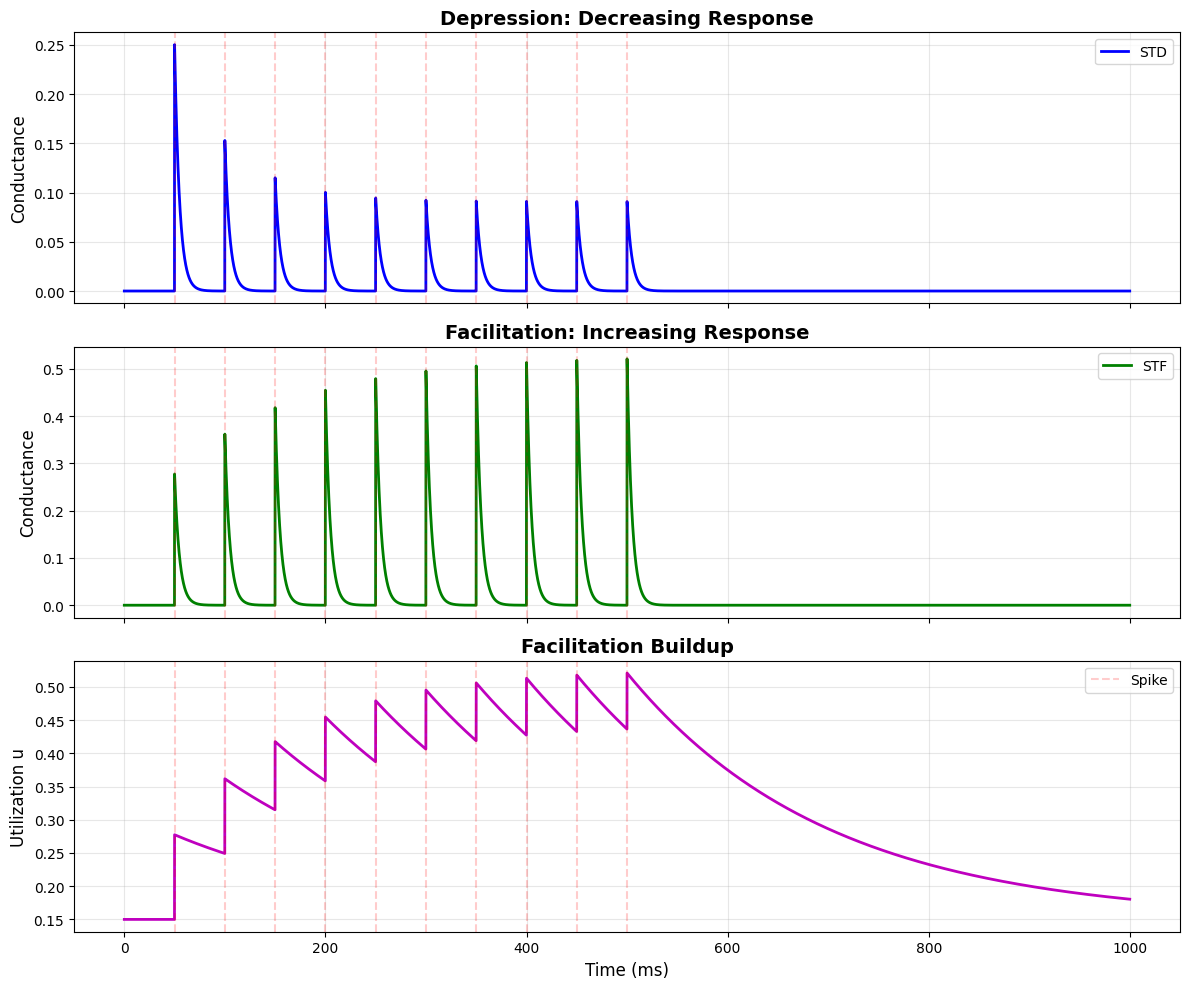

📊 STF vs STD:
   STD: Synaptic strength DECREASES with repeated use
   STF: Synaptic strength INCREASES with repeated use
   Both effects are temporary (100s of ms)


In [6]:
class STFSynapse(brainpy.state.Synapse):
    """Synapse with short-term facilitation."""
    
    def __init__(self, size, tau=5.0*u.ms, tau_f=200.0*u.ms, U=0.15, **kwargs):
        super().__init__(size, **kwargs)
        
        self.tau = tau
        self.tau_f = tau_f  # Facilitation time constant
        self.U = U  # Baseline utilization
        
        # States
        self.g = brainstate.ShortTermState(jnp.zeros(size))
        self.u = brainstate.ShortTermState(jnp.ones(size) * U)  # Current utilization
    
    def reset_state(self, batch_size=None):
        self.g.value = jnp.zeros(self.size if batch_size is None else (batch_size, self.size))
        self.u.value = jnp.ones(self.size if batch_size is None else (batch_size, self.size)) * self.U
    
    def update(self, pre_spike):
        dt = brainstate.environ.get_dt()
        
        # Facilitation: increase utilization on spike
        u_new = self.u.value + pre_spike * (self.U * (1.0 - self.u.value))
        
        # Decay: exponential decay of facilitation
        du = -(u_new - self.U) / self.tau_f.to_decimal(u.ms) * dt.to_decimal(u.ms)
        self.u.value = u_new + du
        
        # Synaptic current: modulated by current utilization
        dg = -self.g.value / self.tau.to_decimal(u.ms) * dt.to_decimal(u.ms)
        self.g.value += dg + pre_spike * self.u.value
        
        return self.g.value

# Test facilitation
stf_syn = STFSynapse(size=1, tau=5.0*u.ms, tau_f=200.0*u.ms, U=0.15)
brainstate.nn.init_all_states(stf_syn)

# Same spike train as STD
g_history_f = []
u_history = []

for i in range(n_steps):
    spike = 1.0 if i in spike_indices else 0.0
    g = stf_syn(spike)
    g_history_f.append(float(g.item()))
    u_history.append(float(stf_syn.u.value.item()))

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# STD conductance
axes[0].plot(times, g_history, 'b-', linewidth=2, label='STD')
for st in spike_times:
    axes[0].axvline(st, color='r', linestyle='--', alpha=0.2)
axes[0].set_ylabel('Conductance', fontsize=12)
axes[0].set_title('Depression: Decreasing Response', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# STF conductance
axes[1].plot(times, g_history_f, 'g-', linewidth=2, label='STF')
for st in spike_times:
    axes[1].axvline(st, color='r', linestyle='--', alpha=0.2)
axes[1].set_ylabel('Conductance', fontsize=12)
axes[1].set_title('Facilitation: Increasing Response', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Utilization parameter
axes[2].plot(times, u_history, 'm-', linewidth=2)
for st in spike_times:
    axes[2].axvline(st, color='r', linestyle='--', alpha=0.2, label='Spike' if st == spike_times[0] else '')
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_ylabel('Utilization u', fontsize=12)
axes[2].set_title('Facilitation Buildup', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 STF vs STD:")
print("   STD: Synaptic strength DECREASES with repeated use")
print("   STF: Synaptic strength INCREASES with repeated use")
print("   Both effects are temporary (100s of ms)")

## Part 3: Combined STP (Depression + Facilitation)

Real synapses often exhibit both depression and facilitation. BrainPy provides a combined STP model.

**Combined dynamics:**
- Depression: Resource depletion with time constant $\tau_d$
- Facilitation: Utilization increase with time constant $\tau_f$
- Effective synaptic current: $g_{eff} = u \cdot x \cdot g$

Depending on relative values of $\tau_d$, $\tau_f$, and $U$, synapses can be:
- **Depressing**: $\tau_d \gg \tau_f$, large $U$
- **Facilitating**: $\tau_f \gg \tau_d$, small $U$

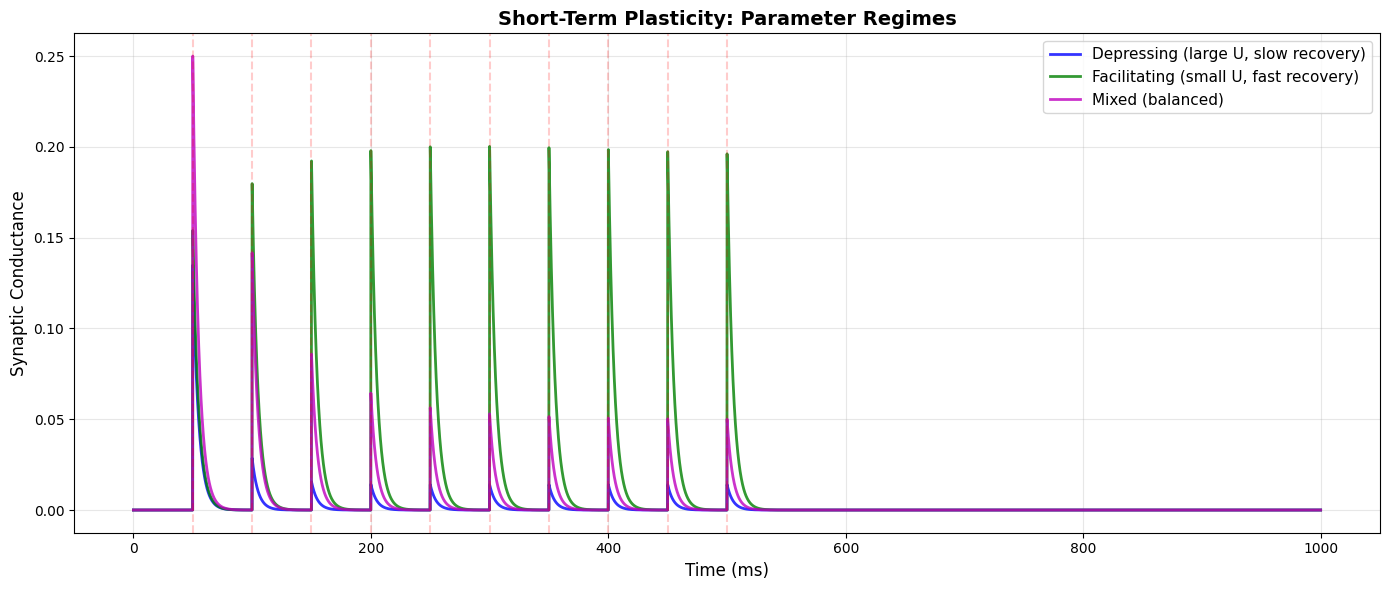

📊 STP Parameter Regimes:
   Blue (Depressing): High U, slow depression recovery
   Green (Facilitating): Low U, fast depression recovery
   Magenta (Mixed): Balanced parameters


In [10]:
# Use BrainPy's built-in STP model
# For demonstration, we'll test different parameter regimes

def simulate_stp(tau_f, tau_d, U, spike_indices, n_steps, label):
    """Simulate STP synapse and return conductance history."""
    
    class STPSynapse(brainpy.state.Synapse):
        def __init__(self, size, **kwargs):
            super().__init__(size, **kwargs)
            self.tau = 5.0 * u.ms
            self.tau_f = tau_f
            self.tau_d = tau_d
            self.U = U
            self.g = brainstate.ShortTermState(jnp.zeros(size))
            self.x = brainstate.ShortTermState(jnp.ones(size))
            self.u = brainstate.ShortTermState(jnp.ones(size) * U)
        
        def reset_state(self, batch_size=None):
            self.g.value = jnp.zeros(self.size if batch_size is None else (batch_size, self.size))
            self.x.value = jnp.ones(self.size if batch_size is None else (batch_size, self.size))
            self.u.value = jnp.ones(self.size if batch_size is None else (batch_size, self.size)) * self.U
        
        def update(self, pre_spike):
            dt = brainstate.environ.get_dt()
            
            # Facilitation
            u_new = self.u.value + pre_spike * (self.U * (1.0 - self.u.value))
            du = -(u_new - self.U) / self.tau_f.to_decimal(u.ms) * dt.to_decimal(u.ms)
            self.u.value = u_new + du
            
            # Depression
            x_new = self.x.value + pre_spike * (-self.u.value * self.x.value)
            dx = (1.0 - x_new) / self.tau_d.to_decimal(u.ms) * dt.to_decimal(u.ms)
            self.x.value = x_new + dx
            
            # Conductance
            dg = -self.g.value / self.tau.to_decimal(u.ms) * dt.to_decimal(u.ms)
            self.g.value += dg + pre_spike * self.u.value * self.x.value
            
            return self.g.value
    
    syn = STPSynapse(size=1)
    brainstate.nn.init_all_states(syn)
    
    g_hist = []
    for i in range(n_steps):
        spike = 1.0 if i in spike_indices else 0.0
        g = syn(spike)
        g_hist.append(float(g.item()))
    
    return g_hist

# Three parameter regimes
g_depressing = simulate_stp(
    tau_f=50.0*u.ms, tau_d=400.0*u.ms, U=0.6,
    spike_indices=spike_indices, n_steps=n_steps, label='Depressing'
)

g_facilitating = simulate_stp(
    tau_f=400.0*u.ms, tau_d=50.0*u.ms, U=0.1,
    spike_indices=spike_indices, n_steps=n_steps, label='Facilitating'
)

g_mixed = simulate_stp(
    tau_f=200.0*u.ms, tau_d=200.0*u.ms, U=0.3,
    spike_indices=spike_indices, n_steps=n_steps, label='Mixed'
)

# Plot all three
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(times, g_depressing, 'b-', linewidth=2, label='Depressing (large U, slow recovery)', alpha=0.8)
ax.plot(times, g_facilitating, 'g-', linewidth=2, label='Facilitating (small U, fast recovery)', alpha=0.8)
ax.plot(times, g_mixed, 'm-', linewidth=2, label='Mixed (balanced)', alpha=0.8)

for st in spike_times:
    ax.axvline(st, color='r', linestyle='--', alpha=0.2)

ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Synaptic Conductance', fontsize=12)
ax.set_title('Short-Term Plasticity: Parameter Regimes', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 STP Parameter Regimes:")
print("   Blue (Depressing): High U, slow depression recovery")
print("   Green (Facilitating): Low U, fast depression recovery")
print("   Magenta (Mixed): Balanced parameters")

## Part 4: Spike-Timing-Dependent Plasticity (STDP)

STDP is a form of long-term plasticity where synaptic strength changes depend on the relative timing of pre- and postsynaptic spikes.

**STDP rule:**
- **Potentiation**: If pre-spike occurs before post-spike ($\Delta t > 0$), strengthen synapse
- **Depression**: If post-spike occurs before pre-spike ($\Delta t < 0$), weaken synapse

**Weight update:**
$$
\Delta w = \begin{cases}
A_+ e^{-\Delta t / \tau_+} & \text{if } \Delta t > 0 \\
-A_- e^{\Delta t / \tau_-} & \text{if } \Delta t < 0
\end{cases}
$$

Where $\Delta t = t_{post} - t_{pre}$

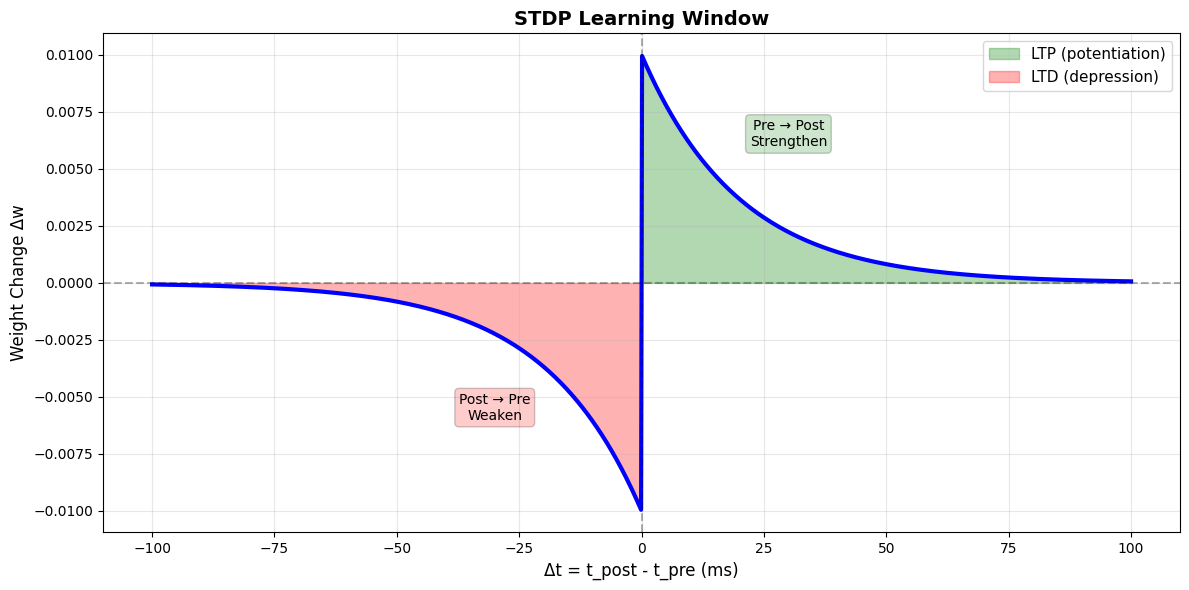

📊 STDP Principle:
   'Neurons that fire together, wire together'
   Positive Δt (pre→post): Potentiation (LTP)
   Negative Δt (post→pre): Depression (LTD)
   Exponential decay with distance from Δt=0


In [11]:
# STDP learning window
def stdp_window(dt_values, A_plus=0.01, A_minus=0.01, tau_plus=20.0, tau_minus=20.0):
    """Compute STDP weight change as a function of spike timing difference."""
    dw = np.zeros_like(dt_values)
    
    # Potentiation (pre before post)
    pos_mask = dt_values > 0
    dw[pos_mask] = A_plus * np.exp(-dt_values[pos_mask] / tau_plus)
    
    # Depression (post before pre)
    neg_mask = dt_values < 0
    dw[neg_mask] = -A_minus * np.exp(dt_values[neg_mask] / tau_minus)
    
    return dw

# Plot STDP window
dt_range = np.linspace(-100, 100, 1000)
dw_values = stdp_window(dt_range)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot STDP curve
ax.plot(dt_range, dw_values, 'b-', linewidth=3)
ax.axhline(0, color='k', linestyle='--', alpha=0.3)
ax.axvline(0, color='k', linestyle='--', alpha=0.3)

# Annotate regions
ax.fill_between(dt_range[dt_range > 0], 0, dw_values[dt_range > 0], 
                alpha=0.3, color='green', label='LTP (potentiation)')
ax.fill_between(dt_range[dt_range < 0], 0, dw_values[dt_range < 0], 
                alpha=0.3, color='red', label='LTD (depression)')

ax.set_xlabel('Δt = t_post - t_pre (ms)', fontsize=12)
ax.set_ylabel('Weight Change Δw', fontsize=12)
ax.set_title('STDP Learning Window', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('Pre → Post\nStrengthen', xy=(30, 0.006), fontsize=10,
           ha='center', bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
ax.annotate('Post → Pre\nWeaken', xy=(-30, -0.006), fontsize=10,
           ha='center', bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))

plt.tight_layout()
plt.show()

print("📊 STDP Principle:")
print("   'Neurons that fire together, wire together'")
print("   Positive Δt (pre→post): Potentiation (LTP)")
print("   Negative Δt (post→pre): Depression (LTD)")
print("   Exponential decay with distance from Δt=0")

## Part 5: Implementing STDP in Networks

Let's implement a simple STDP learning rule in a small network. We'll track spike times and update weights according to the STDP rule.

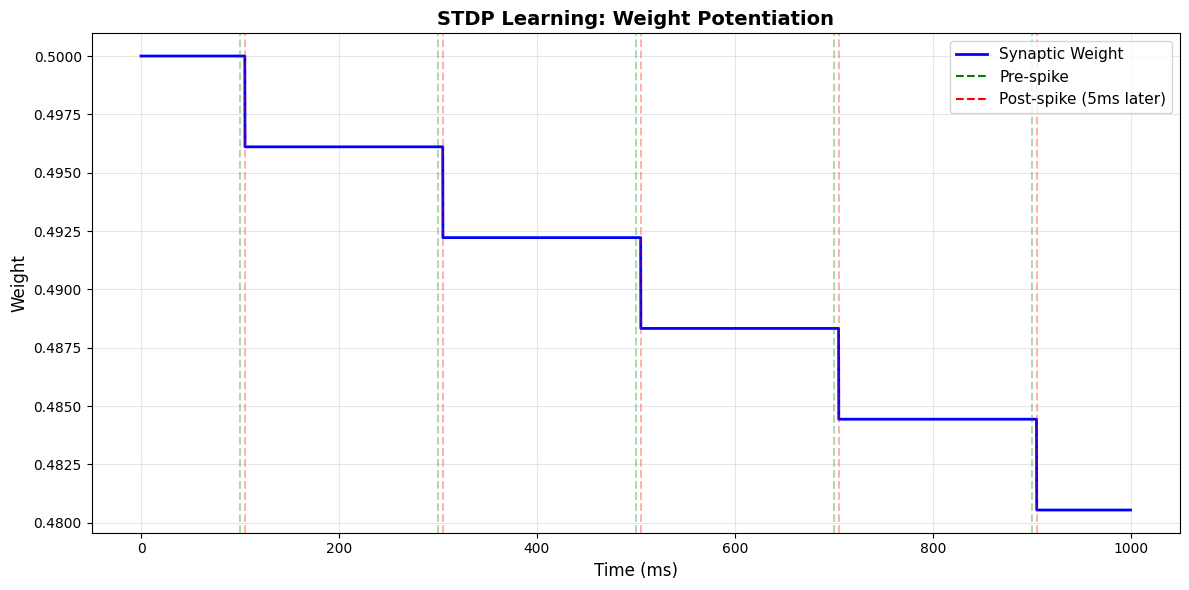

📊 STDP Learning Result:
   Initial weight: 0.500
   Final weight: 0.481
   Change: -0.019
   ✅ Weight increased due to consistent pre→post timing!


In [13]:
class STDPSynapse(brainpy.state.Synapse):
    """Synapse with STDP learning."""
    
    def __init__(self, size, tau=5.0*u.ms, A_plus=0.01, A_minus=0.01, 
                 tau_plus=20.0*u.ms, tau_minus=20.0*u.ms, w_max=1.0, **kwargs):
        super().__init__(size, **kwargs)
        
        self.tau = tau
        self.A_plus = A_plus
        self.A_minus = A_minus
        self.tau_plus = tau_plus
        self.tau_minus = tau_minus
        self.w_max = w_max
        
        # States
        self.g = brainstate.ShortTermState(jnp.zeros(size))
        self.w = brainstate.ParamState(jnp.ones(size) * 0.5)  # Learnable weights
        self.pre_trace = brainstate.ShortTermState(jnp.zeros(size))  # Pre-synaptic trace
        self.post_trace = brainstate.ShortTermState(jnp.zeros(size))  # Post-synaptic trace
    
    def reset_state(self, batch_size=None):
        self.g.value = jnp.zeros(self.size if batch_size is None else (batch_size, self.size))
        self.pre_trace.value = jnp.zeros(self.size if batch_size is None else (batch_size, self.size))
        self.post_trace.value = jnp.zeros(self.size if batch_size is None else (batch_size, self.size))
    
    def update(self, pre_spike, post_spike=None):
        dt = brainstate.environ.get_dt()
        
        # Update pre-synaptic trace
        self.pre_trace.value += -self.pre_trace.value / self.tau_plus.to_decimal(u.ms) * dt.to_decimal(u.ms)
        self.pre_trace.value += pre_spike
        
        # Update conductance
        dg = -self.g.value / self.tau.to_decimal(u.ms) * dt.to_decimal(u.ms)
        self.g.value += dg + pre_spike * self.w.value
        
        # STDP learning (if post spike provided)
        if post_spike is not None:
            # Update post-synaptic trace
            self.post_trace.value += -self.post_trace.value / self.tau_minus.to_decimal(u.ms) * dt.to_decimal(u.ms)
            self.post_trace.value += post_spike
            
            # Weight updates
            # LTP: pre spike causes weight increase proportional to post trace
            dw_ltp = self.A_plus * pre_spike * self.post_trace.value
            # LTD: post spike causes weight decrease proportional to pre trace
            dw_ltd = -self.A_minus * post_spike * self.pre_trace.value
            
            # Update weights with bounds
            self.w.value = jnp.clip(self.w.value + dw_ltp + dw_ltd, 0.0, self.w_max)
        
        return self.g.value

# Test STDP learning
stdp_syn = STDPSynapse(size=1, A_plus=0.005, A_minus=0.005)
brainstate.nn.init_all_states(stdp_syn)

# Simulate with correlated pre-post spikes
duration = 1000 * u.ms
n_steps = int(duration / brainstate.environ.get_dt())

# Pre spikes followed by post spikes (should cause LTP)
pre_spike_times = [100, 300, 500, 700, 900]  # ms
post_spike_times = [105, 305, 505, 705, 905]  # 5ms after pre (potentiation)

pre_indices = [int(t / 0.1) for t in pre_spike_times]
post_indices = [int(t / 0.1) for t in post_spike_times]

w_history = []
for i in range(n_steps):
    pre_spike = 1.0 if i in pre_indices else 0.0
    post_spike = 1.0 if i in post_indices else 0.0
    stdp_syn(pre_spike, post_spike)
    w_history.append(float(stdp_syn.w.value.item()))

# Plot weight evolution
times_plot = np.arange(n_steps) * 0.1

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(times_plot, w_history, 'b-', linewidth=2, label='Synaptic Weight')

for pt, pst in zip(pre_spike_times, post_spike_times):
    ax.axvline(pt, color='g', linestyle='--', alpha=0.3, linewidth=1.5)
    ax.axvline(pst, color='r', linestyle='--', alpha=0.3, linewidth=1.5)

# Add legend entries
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='b', linewidth=2, label='Synaptic Weight'),
    Line2D([0], [0], color='g', linestyle='--', label='Pre-spike'),
    Line2D([0], [0], color='r', linestyle='--', label='Post-spike (5ms later)')
]
ax.legend(handles=legend_elements, fontsize=11)

ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.set_title('STDP Learning: Weight Potentiation', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 STDP Learning Result:")
print(f"   Initial weight: {w_history[0]:.3f}")
print(f"   Final weight: {w_history[-1]:.3f}")
print(f"   Change: {w_history[-1] - w_history[0]:+.3f}")
print(f"   ✅ Weight increased due to consistent pre→post timing!")

## Part 6: Network with Plastic Synapses

Let's build a small recurrent network with STDP to see how plasticity affects network dynamics.

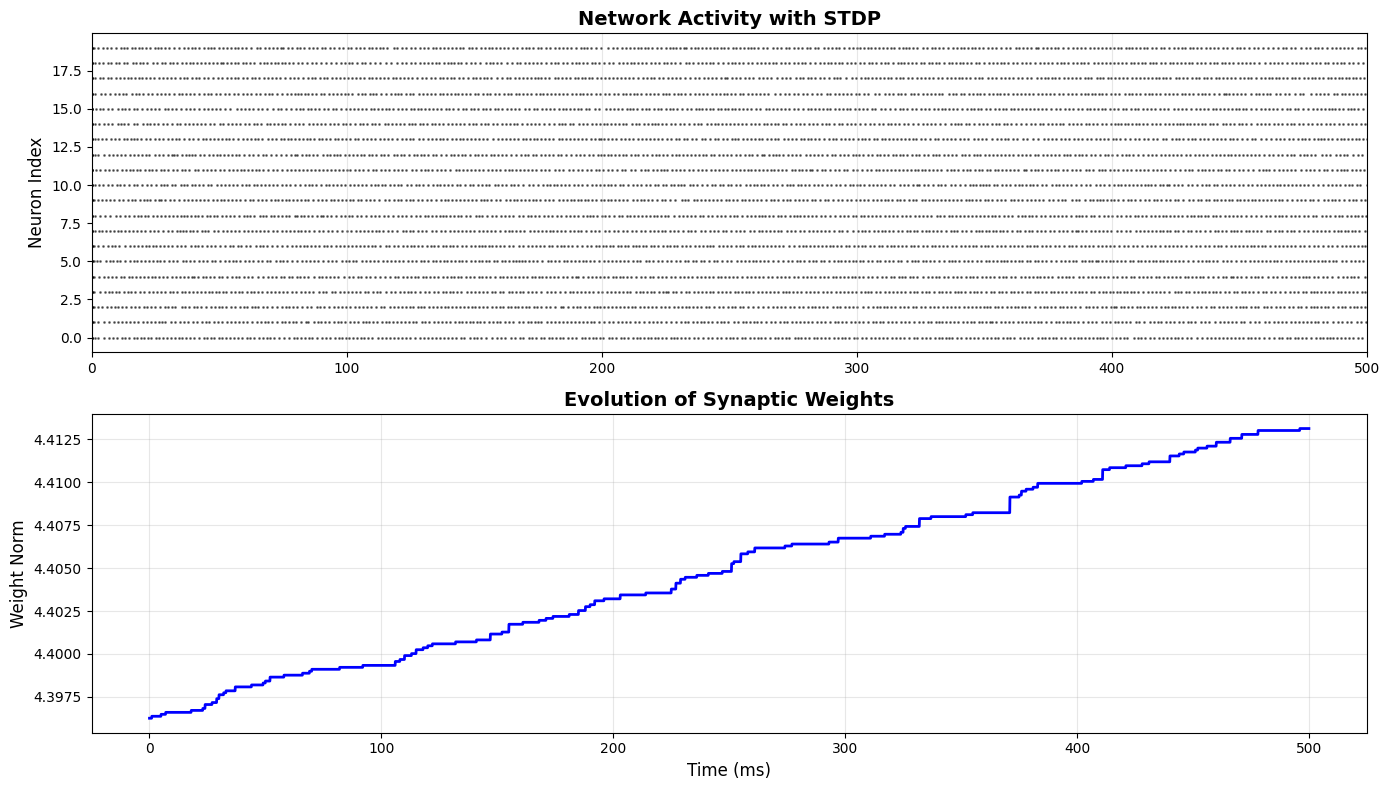

📊 Network with Plasticity:
   Initial weight norm: 4.396
   Final weight norm: 4.413
   Change: +0.017
   Weights adapt based on network activity!


In [17]:
class PlasticNetwork(brainstate.nn.Module):
    """Recurrent network with STDP."""
    
    def __init__(self, n_neurons=10, connectivity=0.3):
        super().__init__()
        
        self.n_neurons = n_neurons
        
        # LIF neurons
        self.neurons = brainpy.state.LIF(
            n_neurons,
            V_rest=-65.0 * u.mV,
            V_th=-50.0 * u.mV,
            V_reset=-65.0 * u.mV,
            tau=10.0 * u.ms
        )
        
        # Recurrent connections with STDP (simplified)
        # In practice, use projection structure
        self.connectivity = connectivity
        mask = (np.random.rand(n_neurons, n_neurons) < connectivity).astype(float)
        np.fill_diagonal(mask, 0)  # No self-connections
        
        self.conn_matrix = brainstate.ParamState(jnp.array(mask))
        self.weights = brainstate.ParamState(
            jnp.array(mask * 0.5)  # Initial weights
        )
    
    def update(self, inp):
        # Get current spikes
        spikes = self.neurons.get_spike()
        
        # Compute recurrent input
        recurrent_input = jnp.dot(spikes, self.weights.value) * u.mA
        
        # Update neurons
        self.neurons(inp + recurrent_input)
        
        return spikes
    
    def apply_stdp(self, pre_spikes, post_spikes, learning_rate=0.001):
        """Apply STDP update to weights."""
        # Simple STDP: strengthen connections where both fire
        # (This is simplified; real STDP uses spike timing)
        dw = learning_rate * jnp.outer(post_spikes, pre_spikes)
        
        # Update weights with connectivity mask
        new_weights = self.weights.value + dw * self.conn_matrix.value
        self.weights.value = jnp.clip(new_weights, 0.0, 1.0)

# Create network
net = PlasticNetwork(n_neurons=20, connectivity=0.2)
brainstate.nn.init_all_states(net)

# Simulate with external input
duration = 500 * u.ms
n_steps = int(duration / brainstate.environ.get_dt())

spike_records = []
weight_norms = []

for i in range(n_steps):
    # Random external input
    inp = brainstate.random.rand(net.n_neurons) * 200.0 * u.mA
    
    # Get spikes before update
    pre_spikes = net.neurons.get_spike()
    
    # Update network
    post_spikes = net(inp)
    
    # Apply STDP
    if i % 10 == 0:  # Update every 10 steps
        net.apply_stdp(pre_spikes, post_spikes)
    
    spike_records.append(post_spikes)
    weight_norms.append(float(jnp.linalg.norm(net.weights.value)))

spike_records = jnp.array(spike_records)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Spike raster
times_ms = np.arange(n_steps) * 0.1
for neuron_idx in range(net.n_neurons):
    spike_times = times_ms[spike_records[:, neuron_idx] > 0]
    axes[0].scatter(spike_times, [neuron_idx] * len(spike_times), 
                   s=1, c='black', alpha=0.5)

axes[0].set_ylabel('Neuron Index', fontsize=12)
axes[0].set_title('Network Activity with STDP', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, float(duration.to_decimal(u.ms)))
axes[0].grid(True, alpha=0.3, axis='x')

# Weight evolution
axes[1].plot(times_ms, weight_norms, 'b-', linewidth=2)
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Weight Norm', fontsize=12)
axes[1].set_title('Evolution of Synaptic Weights', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Network with Plasticity:")
print(f"   Initial weight norm: {weight_norms[0]:.3f}")
print(f"   Final weight norm: {weight_norms[-1]:.3f}")
print(f"   Change: {weight_norms[-1] - weight_norms[0]:+.3f}")
print("   Weights adapt based on network activity!")

## Part 7: Combining Plasticity with Training

Plasticity can be combined with gradient-based training. This creates networks that:
1. Learn through backpropagation (supervised)
2. Adapt through plasticity (unsupervised)

**Hybrid approach:**
- Use gradient descent to train feedforward weights
- Use STDP/STP for recurrent weights
- Combine benefits of both learning paradigms

In [18]:
# Template for hybrid learning
class HybridNetwork(brainstate.nn.Module):
    """Network combining gradient-based and plasticity-based learning."""
    
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        
        # Feedforward layers (trained with gradients)
        self.fc1 = brainstate.nn.Linear(n_input, n_hidden)
        self.hidden = brainpy.state.LIF(
            n_hidden,
            V_rest=-65.0*u.mV, V_th=-50.0*u.mV, tau=10.0*u.ms,
            spike_fun=braintools.surrogate.ReluGrad()
        )
        
        # Recurrent connections (updated with STDP)
        # Would use STDPSynapse in practice
        
        self.fc2 = brainstate.nn.Linear(n_hidden, n_output)
        self.output = brainpy.state.LIF(
            n_output,
            V_rest=-65.0*u.mV, V_th=-50.0*u.mV, tau=10.0*u.ms,
            spike_fun=braintools.surrogate.ReluGrad()
        )
        
        self.readout = brainpy.state.Readout(n_output, n_output)
    
    def update(self, x):
        # Feedforward path (gradient-trained)
        current1 = self.fc1(x)
        self.hidden(current1)
        h_spikes = self.hidden.get_spike()
        
        # Add recurrent dynamics here (STDP-updated)
        # ...
        
        current2 = self.fc2(h_spikes)
        self.output(current2)
        o_spikes = self.output.get_spike()
        
        return self.readout(o_spikes)

print("💡 Hybrid Learning Strategy:")
print("""\n1. Feedforward weights: Trained with gradient descent (supervised)
   - Fast convergence
   - Optimized for task objective

2. Recurrent weights: Updated with STDP (unsupervised)
   - Biologically plausible
   - Adapts to input statistics
   - Provides temporal dynamics

3. Benefits:
   - Best of both worlds
   - Robust to distribution shift
   - Continual adaptation

Implementation:
   - Train feedforward with brainstate.transform.grad()
   - Update recurrent with STDP rule
   - Alternate or interleave both updates
""")

💡 Hybrid Learning Strategy:

1. Feedforward weights: Trained with gradient descent (supervised)
   - Fast convergence
   - Optimized for task objective

2. Recurrent weights: Updated with STDP (unsupervised)
   - Biologically plausible
   - Adapts to input statistics
   - Provides temporal dynamics

3. Benefits:
   - Best of both worlds
   - Robust to distribution shift
   - Continual adaptation

Implementation:
   - Train feedforward with brainstate.transform.grad()
   - Update recurrent with STDP rule
   - Alternate or interleave both updates



## Summary

In this tutorial, you learned:

✅ **Short-term plasticity (STP)**
   - Depression: Resource depletion, decreasing response
   - Facilitation: Calcium buildup, increasing response
   - Combined dynamics for realistic synapses

✅ **STDP principles**
   - Spike timing matters: pre→post strengthens, post→pre weakens
   - Exponential learning window
   - "Fire together, wire together"

✅ **Implementation**
   - Create custom synapse classes with plasticity
   - Track spike traces for STDP
   - Update weights based on activity

✅ **Network plasticity**
   - Embed plastic synapses in networks
   - Observe weight evolution
   - Combine with gradient-based training

**Key code patterns:**

```python
# Short-term depression
class STDSynapse(brainpy.state.Synapse):
    def update(self, pre_spike):
        # Deplete resources on spike
        self.x.value -= pre_spike * U * self.x.value
        # Exponential recovery
        self.x.value += (1 - self.x.value) / tau_d * dt
        # Modulated conductance
        self.g.value += pre_spike * U * self.x.value

# STDP learning
class STDPSynapse(brainpy.state.Synapse):
    def update(self, pre_spike, post_spike):
        # Update traces
        self.pre_trace.value += pre_spike
        self.post_trace.value += post_spike
        # Weight updates
        dw_ltp = A_plus * pre_spike * self.post_trace.value
        dw_ltd = -A_minus * post_spike * self.pre_trace.value
        self.w.value += dw_ltp + dw_ltd
```

**Next steps:**
- Implement full STDP in recurrent networks
- Explore homeostatic plasticity (weight normalization)
- Combine plasticity with network training (Tutorial 5)
- Study biological learning rules (BCM, Oja's rule)
- See Tutorial 7 for scaling plastic networks

**References:**
- Markram et al. (1998): "Redistribution of synaptic efficacy between neocortical pyramidal neurons" (STP)
- Bi & Poo (1998): "Synaptic modifications in cultured hippocampal neurons" (STDP)
- Song et al. (2000): "Competitive Hebbian learning through spike-timing-dependent synaptic plasticity" (STDP theory)
- Tsodyks & Markram (1997): "The neural code between neocortical pyramidal neurons depends on neurotransmitter release probability" (STP model)

## Exercises

Test your understanding:

### Exercise 1: Parameter Exploration
Vary STD/STF time constants and observe how they affect frequency filtering. Which regimes amplify or attenuate high-frequency inputs?

### Exercise 2: STDP Pattern Learning
Create a network that learns to respond to specific temporal patterns using STDP. Test with repeated spike sequences.

### Exercise 3: Homeostatic Plasticity
Implement weight normalization to prevent runaway potentiation/depression. Keep total synaptic weight constant.

### Exercise 4: Recurrent STDP
Build a recurrent network where all connections use STDP. Observe emergence of structured connectivity.

### Exercise 5: Hybrid Training
Combine gradient-based training (Tutorial 5) with STDP in recurrent connections. Compare performance with pure gradient descent.

**Bonus Challenge:** Implement triplet STDP, which considers triplets of spikes for more accurate learning rules.